In [1]:
from spectral import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import constants
import img
import pandas as pd
import os
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing
from scipy.optimize import curve_fit
from scipy.optimize import minimize, Bounds
import spectres
import seaborn as sns

In [2]:
def load_flux(fluxname):

    with open(fluxname, 'r') as file:
        data = file.readlines()
        #print(data)
        size = len(data)
        #print(size)
        flux = np.zeros(size)
        wavelengths = np.zeros(size)
        for i in range(size):
            flux[i]=(float(data[i].strip().split(" ,")[1]))
            wavelengths[i]=(float(data[i].strip().split(",")[0]))

    return flux,wavelengths

In [3]:
flux , wavelengths = load_flux('m3_solarflux.txt')

In [4]:
data5 = np.loadtxt('5thband.txt')

In [5]:
data6 = np.loadtxt('6thband.txt')

In [6]:
data10 = np.loadtxt('10thband.txt')

In [7]:
data22 = np.loadtxt('22thband.txt')

In [8]:
data25 = np.loadtxt('25thband.txt')

In [9]:
data30 = np.loadtxt('30thband.txt')

In [10]:
data35 = np.loadtxt('35thband.txt')

In [11]:
data40 = np.loadtxt('40thband.txt')

In [12]:
data45 = np.loadtxt('45thband.txt')

In [13]:
data50 = np.loadtxt('binned_file.txt')

In [14]:
data60 = np.loadtxt('60thband.txt')

In [15]:
data70 = np.loadtxt('70thband.txt')

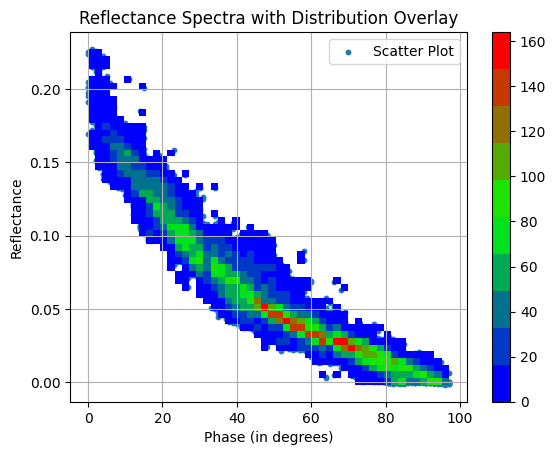

In [66]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data5[:, 0], data5[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data5[:, 0], y=data5[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/1373362475.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.2471208469403776, Error = 0.0061560480012246505
Parameter 1: Value = 0.2427729183524787, Error = 0.00914621278707716
Parameter 2: Value = 0.15296036177386557, Error = 0.004546993804496431
Parameter 3: Value = 3.1999996030483358, Error = 0.04777625929198332


/tmp/ipykernel_3507/1373362475.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


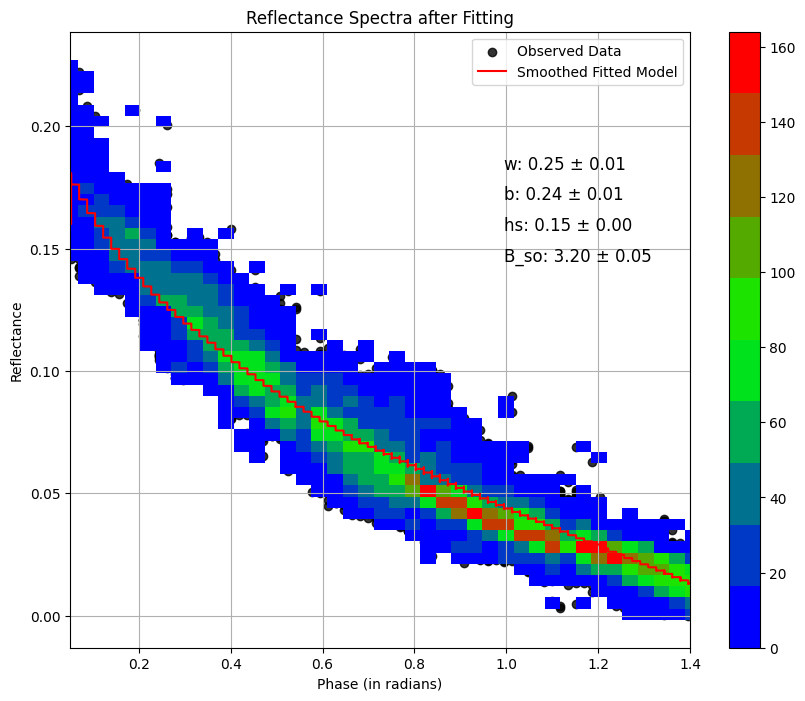

In [67]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data5[:,1]*np.pi)/180
g = (data5[:,0]*np.pi)/180
e = (data5[:,2]*np.pi)/180
y_observed = data5[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data5[:,1]*np.pi)/180
    e = (data5[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p5 = popt
p5err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


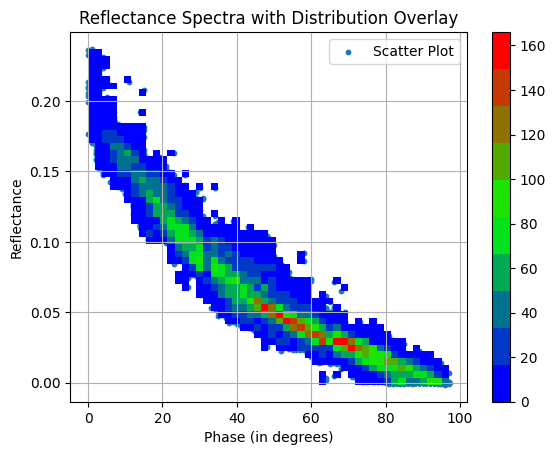

In [30]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data6[:, 0], data6[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data6[:, 0], y=data6[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/1196591491.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.2558289254764142, Error = 0.006306274528080875
Parameter 1: Value = 0.24188133959026947, Error = 0.00918711173776599
Parameter 2: Value = 0.15602269684045134, Error = 0.004648564942640763
Parameter 3: Value = 3.1999990652093238, Error = 0.04809365859912216


/tmp/ipykernel_3507/1196591491.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


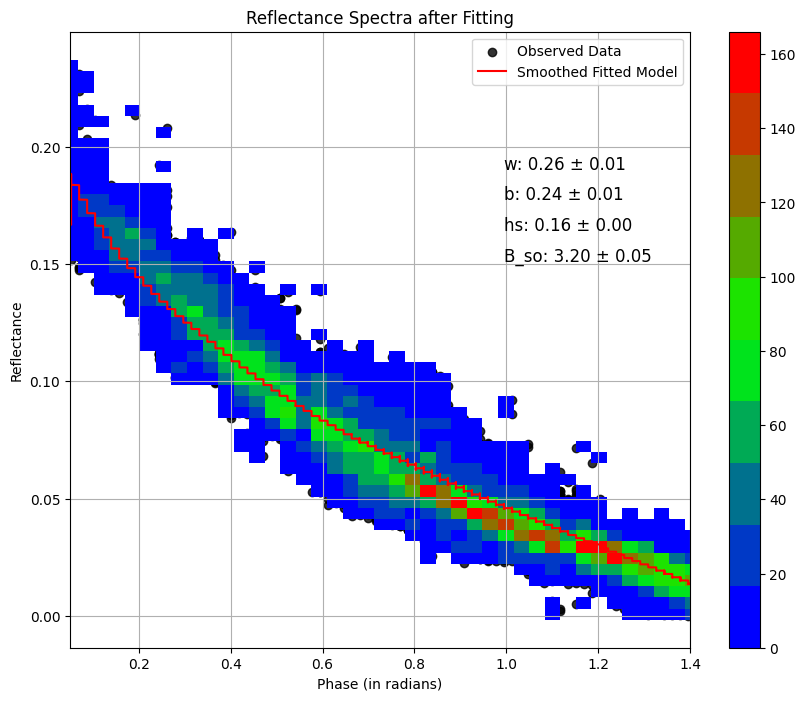

In [31]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data6[:,1]*np.pi)/180
g = (data6[:,0]*np.pi)/180
e = (data6[:,2]*np.pi)/180
y_observed = data6[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data6[:,1]*np.pi)/180
    e = (data6[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p6 = popt
p6err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


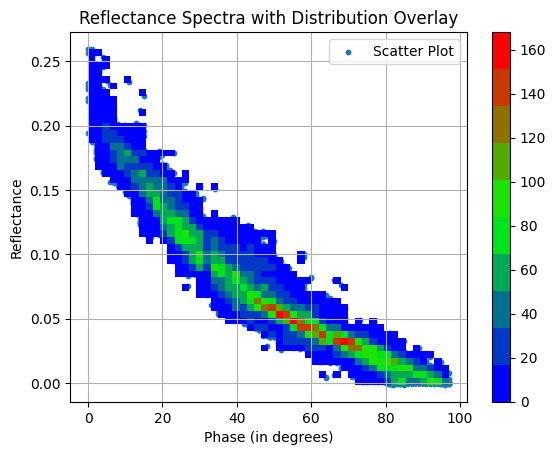

In [32]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data10[:, 0], data10[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data10[:, 0], y=data10[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/2901839899.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.27844604884042445, Error = 0.006622958347728059
Parameter 1: Value = 0.24086053818910355, Error = 0.009224069307848906
Parameter 2: Value = 0.1650962226480206, Error = 0.005000163190870026
Parameter 3: Value = 3.1999976953784968, Error = 0.04970941098896805


/tmp/ipykernel_3507/2901839899.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


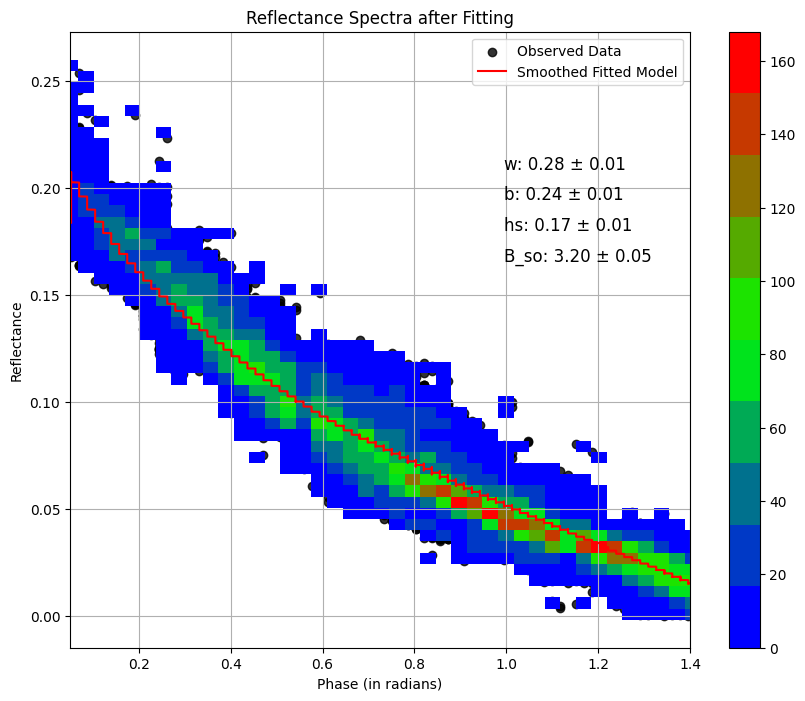

In [33]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data10[:,1]*np.pi)/180
g = (data10[:,0]*np.pi)/180
e = (data10[:,2]*np.pi)/180
y_observed = data10[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data10[:,1]*np.pi)/180
    e = (data10[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p10 = popt
p10err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


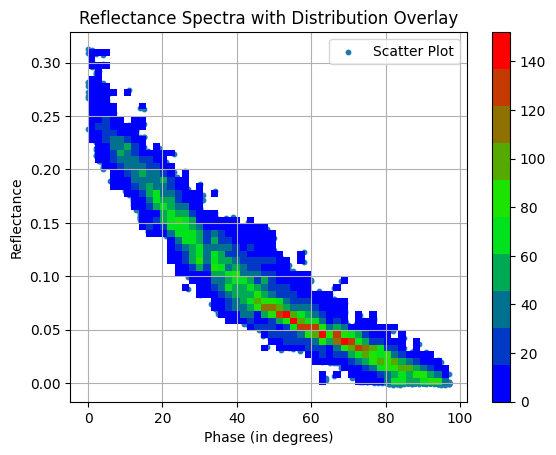

In [34]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data22[:, 0], data22[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data22[:, 0], y=data22[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/2753532744.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.3294999516535432, Error = 0.007799329256900744
Parameter 1: Value = 0.23673496034048253, Error = 0.010035156164159661
Parameter 2: Value = 0.16986591403603427, Error = 0.00537276637905656
Parameter 3: Value = 3.199998973646438, Error = 0.05028594943466487


/tmp/ipykernel_3507/2753532744.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


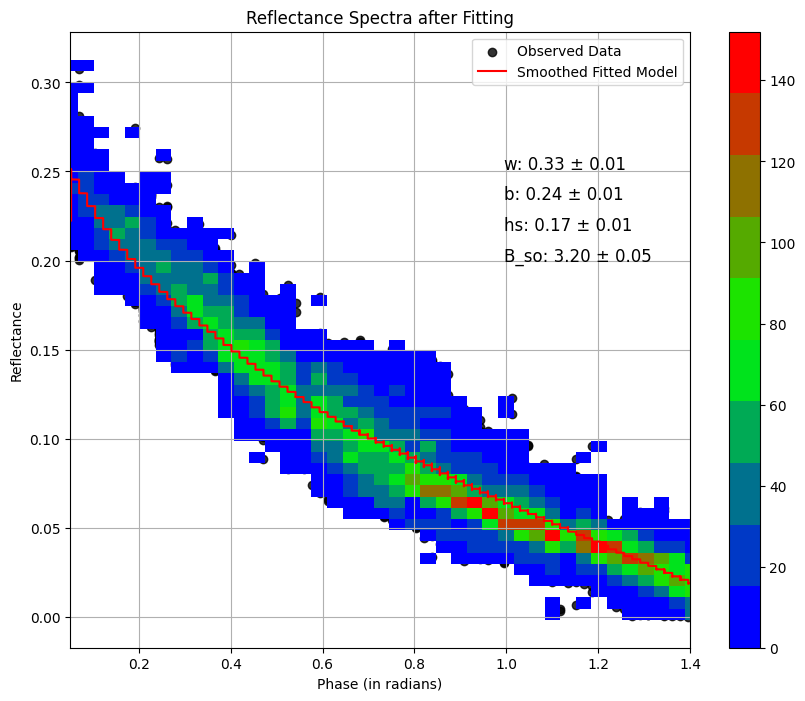

In [35]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data22[:,1]*np.pi)/180
g = (data22[:,0]*np.pi)/180
e = (data22[:,2]*np.pi)/180
y_observed = data22[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data22[:,1]*np.pi)/180
    e = (data22[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p22 = popt
p22err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


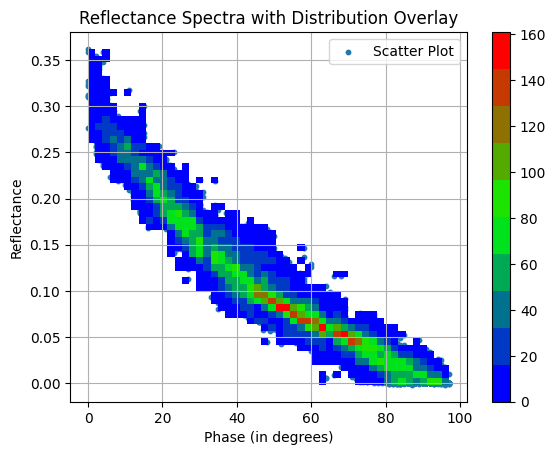

In [36]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data25[:, 0], data25[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data25[:, 0], y=data25[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/3791463238.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.3771475260239706, Error = 0.007778205871171059
Parameter 1: Value = 0.236537292095034, Error = 0.00954950946432107
Parameter 2: Value = 0.1914690736196346, Error = 0.0060824233189895075
Parameter 3: Value = 3.19999845398533, Error = 0.05326887534274896


/tmp/ipykernel_3507/3791463238.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


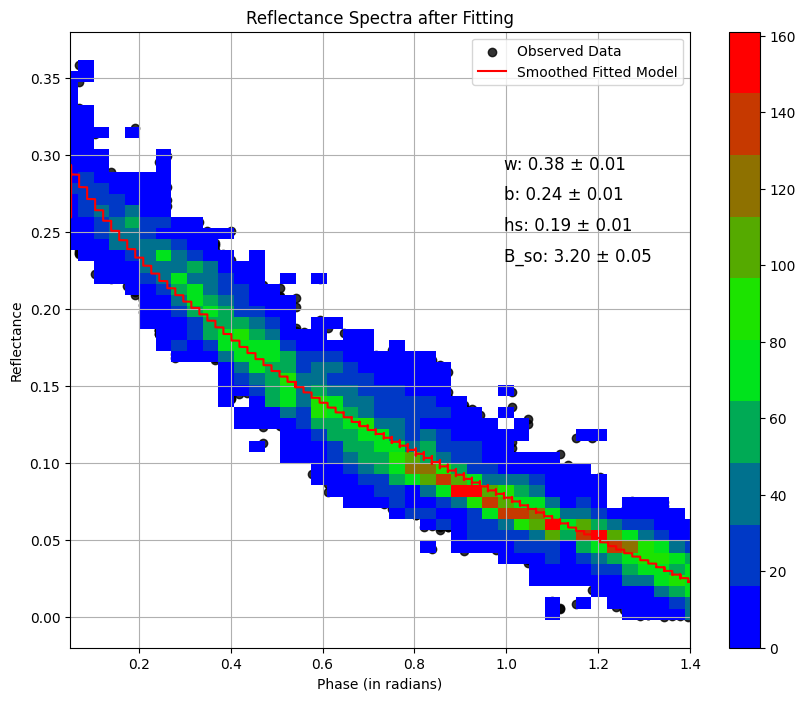

In [37]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data25[:,1]*np.pi)/180
g = (data25[:,0]*np.pi)/180
e = (data25[:,2]*np.pi)/180
y_observed = data25[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data25[:,1]*np.pi)/180
    e = (data25[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p25 = popt
p25err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


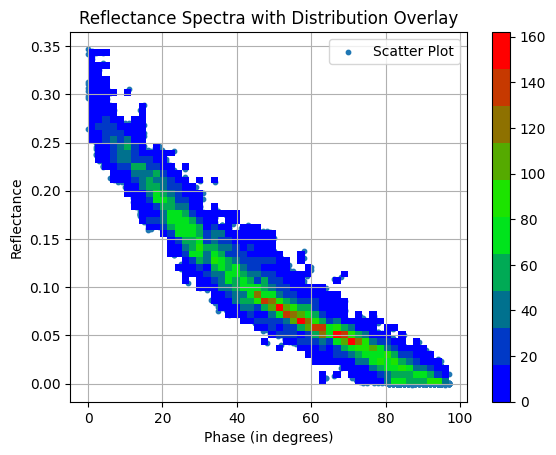

In [38]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data30[:, 0], data30[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data30[:, 0], y=data30[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/2282884649.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.364161080448939, Error = 0.007715297886046156
Parameter 1: Value = 0.23739696902558444, Error = 0.009589003377924983
Parameter 2: Value = 0.18217258060038508, Error = 0.005725016104556908
Parameter 3: Value = 3.1999999503646683, Error = 0.05152300305181331


/tmp/ipykernel_3507/2282884649.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


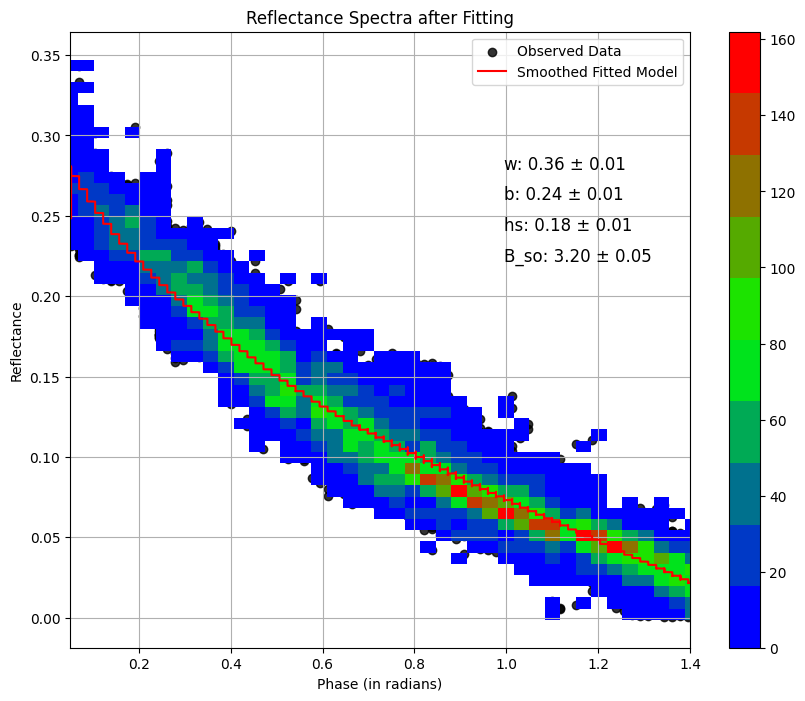

In [40]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data30[:,1]*np.pi)/180
g = (data30[:,0]*np.pi)/180
e = (data30[:,2]*np.pi)/180
y_observed = data30[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data30[:,1]*np.pi)/180
    e = (data30[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p30 = popt
p30err = param_errors


# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


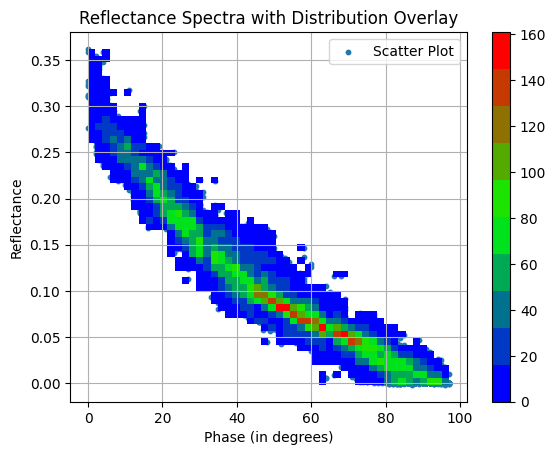

In [41]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data35[:, 0], data35[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data35[:, 0], y=data35[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/3892824605.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.3771475260239706, Error = 0.007778205871171059
Parameter 1: Value = 0.236537292095034, Error = 0.00954950946432107
Parameter 2: Value = 0.1914690736196346, Error = 0.0060824233189895075
Parameter 3: Value = 3.19999845398533, Error = 0.05326887534274896


/tmp/ipykernel_3507/3892824605.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


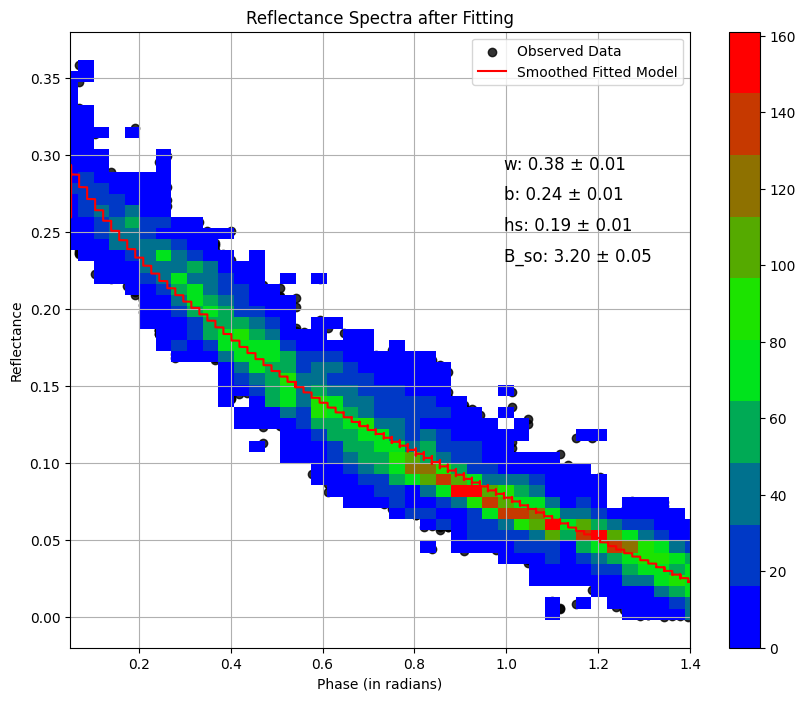

In [42]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data35[:,1]*np.pi)/180
g = (data35[:,0]*np.pi)/180
e = (data35[:,2]*np.pi)/180
y_observed = data35[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data35[:,1]*np.pi)/180
    e = (data35[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p35 = popt
p35err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


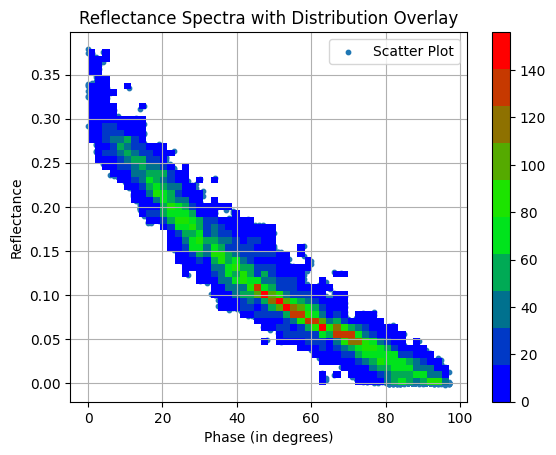

In [43]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data40[:, 0], data40[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data40[:, 0], y=data40[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/3463052335.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.3908513881795351, Error = 0.007985545904285265
Parameter 1: Value = 0.23434068118014337, Error = 0.009651748195158405
Parameter 2: Value = 0.20616289896485107, Error = 0.006714698162302009
Parameter 3: Value = 3.1999999997966158, Error = 0.05623575794497935


/tmp/ipykernel_3507/3463052335.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


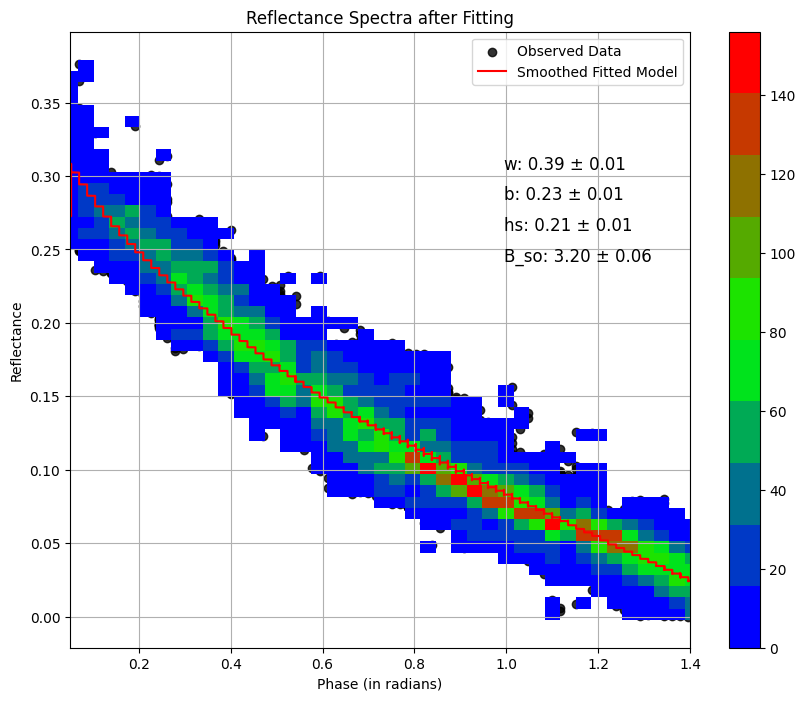

In [44]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data40[:,1]*np.pi)/180
g = (data40[:,0]*np.pi)/180
e = (data40[:,2]*np.pi)/180
y_observed = data40[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data40[:,1]*np.pi)/180
    e = (data40[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p40 = popt
p40err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


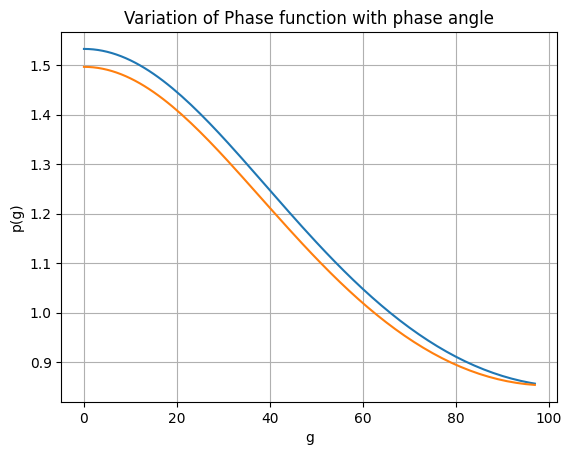

In [45]:
plt.plot((g*180)/np.pi,p(g,0.2343))
plt.plot((g*180)/np.pi,p(g,0.2427))
plt.grid()
plt.xlabel('g')
plt.ylabel('p(g)')
plt.title('Variation of Phase function with phase angle')
plt.show()

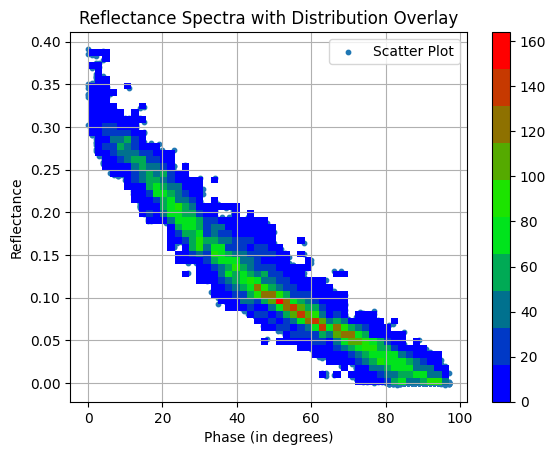

In [46]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data45[:, 0], data45[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data45[:, 0], y=data45[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/3257233382.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.40085939272692495, Error = 0.008186936651337715
Parameter 1: Value = 0.2326560621847271, Error = 0.009791030736160557
Parameter 2: Value = 0.2129163661728174, Error = 0.00701814853930757
Parameter 3: Value = 3.199998787201439, Error = 0.057232439951934846


/tmp/ipykernel_3507/3257233382.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


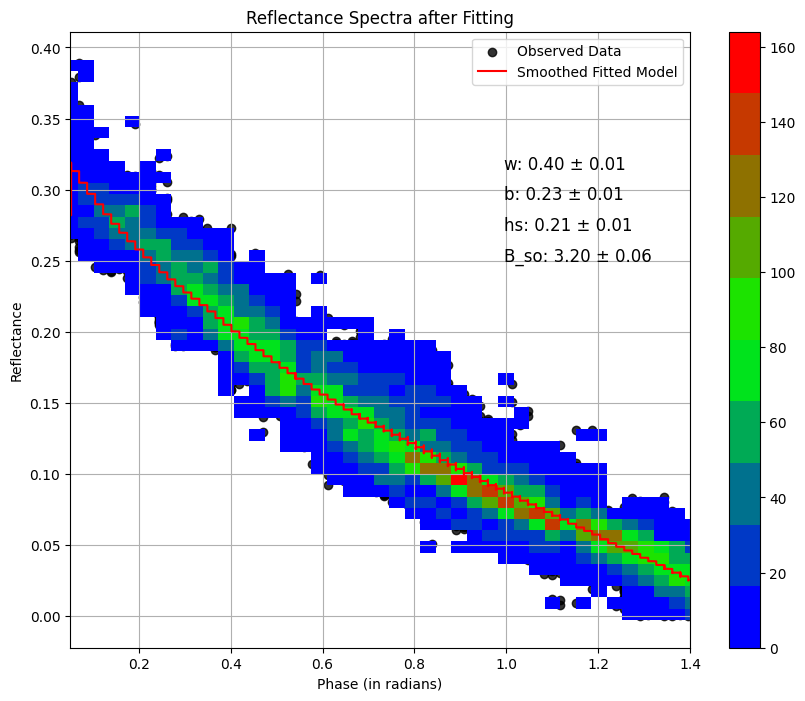

In [47]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data45[:,1]*np.pi)/180
g = (data45[:,0]*np.pi)/180
e = (data45[:,2]*np.pi)/180
y_observed = data45[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data45[:,1]*np.pi)/180
    e = (data45[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p45 = popt
p45err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


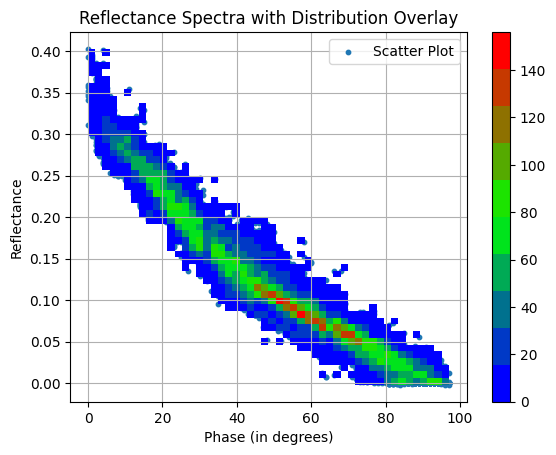

In [48]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data50[:, 0], data50[:, 3] * np.pi, marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data50[:, 0], y=data50[:, 3] * np.pi, bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/4113310145.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.40903726195078244, Error = 0.008200897049601632
Parameter 1: Value = 0.23306375668272603, Error = 0.009742267986588424
Parameter 2: Value = 0.2220421164113678, Error = 0.007500812807368212
Parameter 3: Value = 3.199999999274231, Error = 0.06020012896086946


/tmp/ipykernel_3507/4113310145.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


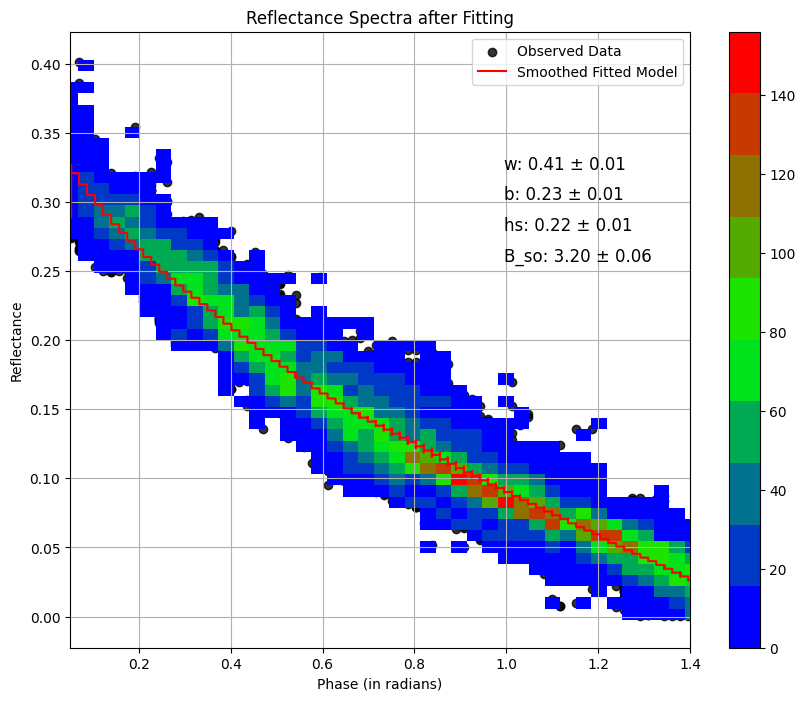

In [49]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data50[:,1]*np.pi)/180
g = (data50[:,0]*np.pi)/180
e = (data50[:,2]*np.pi)/180
y_observed = data50[:,3]*np.pi

def RADF(g, w, b, hs, B_so):
    i = (data50[:,1]*np.pi)/180
    e = (data50[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p50 = popt
p50err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


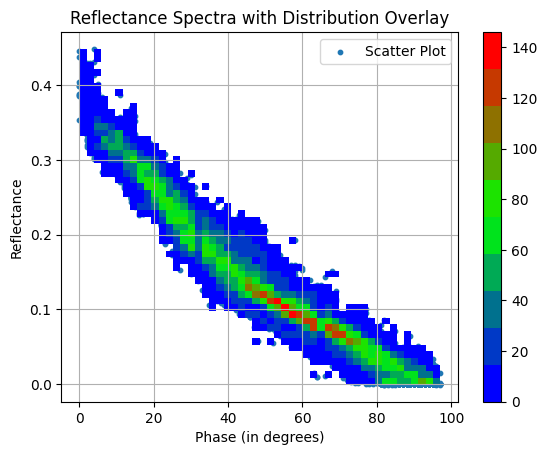

In [50]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data60[:, 0], data60[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data60[:, 0], y=data60[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/1845532674.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.4544654327509035, Error = 0.00870791663156912
Parameter 1: Value = 0.23221682255003248, Error = 0.010191193246393759
Parameter 2: Value = 0.22547793659064272, Error = 0.00789930902270079
Parameter 3: Value = 3.199998706290868, Error = 0.061363249756756916


/tmp/ipykernel_3507/1845532674.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


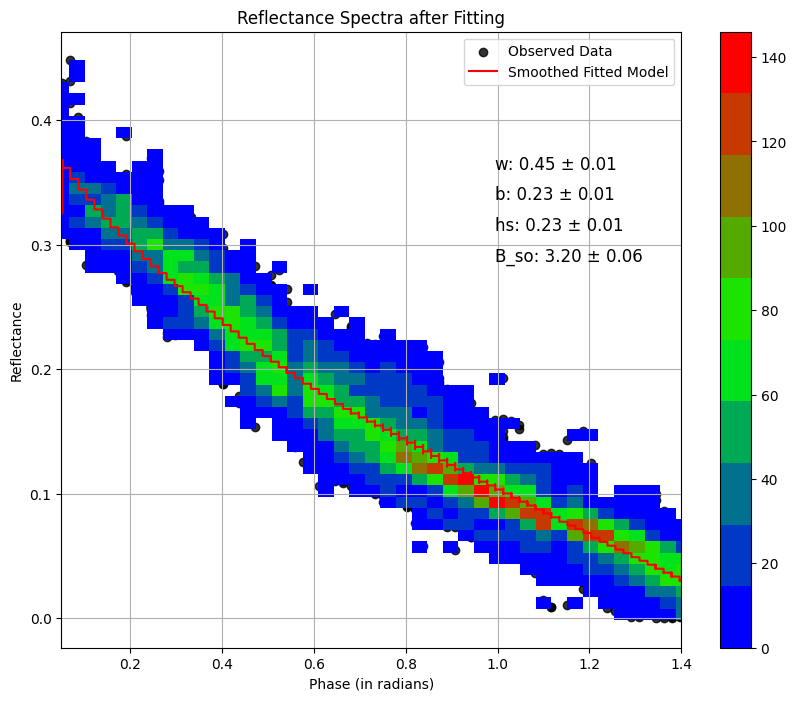

In [51]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data60[:,1]*np.pi)/180
g = (data60[:,0]*np.pi)/180
e = (data60[:,2]*np.pi)/180
y_observed = data60[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data60[:,1]*np.pi)/180
    e = (data60[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p60 = popt
p60err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


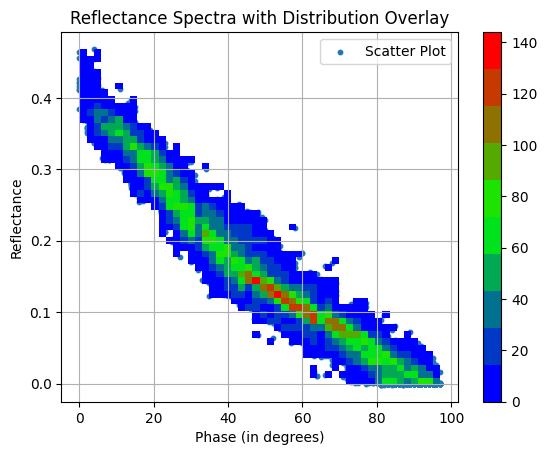

In [52]:
from matplotlib.colors import LinearSegmentedColormap

# Assuming 'data' is your numpy array

# Create a custom RGB colormap
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create a scatter plot
plt.scatter(data70[:, 0], data70[:, 3], marker='o', s=10, label='Scatter Plot')

# Create a 2D histogram (heatmap) to represent the distribution
sns.histplot(x=data70[:, 0], y=data70[:, 3], bins=50, cmap=cm, cbar=True)

plt.xlabel('Phase (in degrees)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra with Distribution Overlay')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_3507/1763077243.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


Parameter 0: Value = 0.48472431607412575, Error = 0.008909919421810495
Parameter 1: Value = 0.23041762468996366, Error = 0.010149006909324411
Parameter 2: Value = 0.2625061943216396, Error = 0.009876999864281972
Parameter 3: Value = 3.199999998132852, Error = 0.07030916352747864


/tmp/ipykernel_3507/1763077243.py:18: RuntimeWarning: invalid value encountered in log
  return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


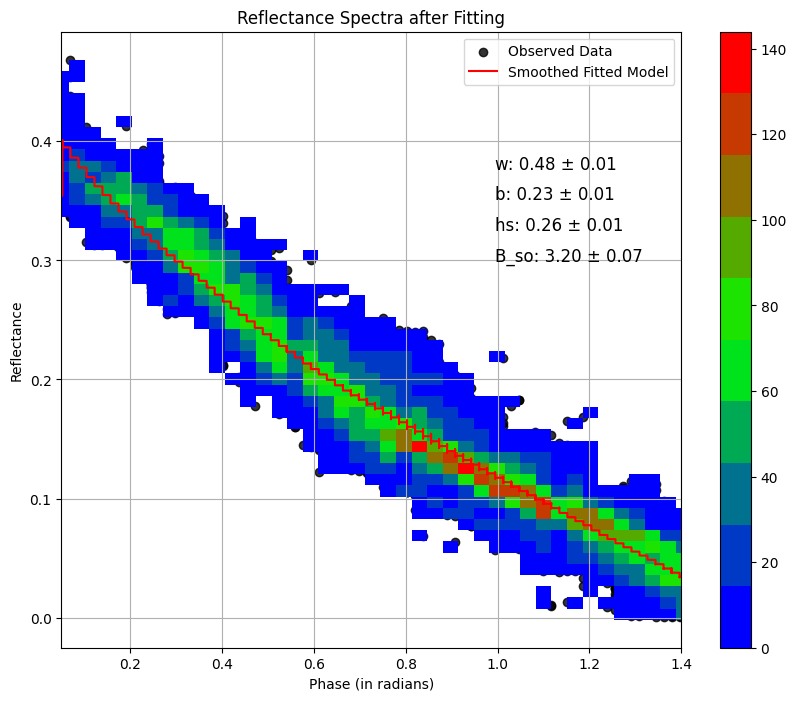

In [53]:
def p(g, b):
    term1 = ((1 + c(g, b)) / 2) * ((1 - b**2) / (1 - 2 * b * np.cos(g) + b**2)**(3/2))
    term2 = ((1 - c(g, b)) / 2) * ((1 - b**2) / (1 + 2 * b * np.cos(g) + b**2)**(3/2))
    return term1 + term2


def c(g, b):
    return 3.29 * np.exp(-17.4 * b**2) - 0.98

def Bs(g, hs):
    return 1 / (1 + (np.tan(g/2))/hs)

def M(i, e, w):
    return H(np.cos(i), w) * H(np.cos(e), w) - 1

def H(x, w):
    r0 = (1 - np.sqrt(1 - w)) / (1 + np.sqrt(1 - w))
    return (1 - w * x*(r0 + ((1 - 2 * r0 * x)/2) * np.log((1 + x )/x)))**(-1)


i = (data70[:,1]*np.pi)/180
g = (data70[:,0]*np.pi)/180
e = (data70[:,2]*np.pi)/180
y_observed = data70[:,3]

def RADF(g, w, b, hs, B_so):
    i = (data70[:,1]*np.pi)/180
    e = (data70[:,2]*np.pi)/180
    mu = np.cos(e)
    mu0 = np.cos(i)
    results1 = (w / 4) * (mu0 / (mu0 + mu)) * (p(g, b) * (1 + B_so * Bs(g, hs)) + M(i, e, w))
    
    mean_value = np.nanmean(results1)
    results = np.where(np.isnan(results1), mean_value, results1)
    
    return results

def smooth_fitted_line(g, *popt):
    fitted_values = RADF(g, *popt)
    window_size = 200 # Adjust the window size as needed
    smoothed_values = np.convolve(fitted_values, np.ones(window_size)/window_size, mode='same')
    return smoothed_values

initial_guess = [0.2, 0.4, 0.06, 2.2]  # Initial guess for [w, b, hs, B_so]

# Bounds for parameters
bounds = ([0.1, 0, 0, 1.6], [0.5, 1, 0.35, 3.2])  # No bounds, adjust according to your problem
# Call curve_fit with g as the independent variable
popt, pcov = curve_fit(RADF, g, y_observed, p0=initial_guess,bounds=bounds)

# Extract parameter errors from the covariance matrix
param_errors = np.sqrt(np.diag(pcov))

p70 = popt
p70err = param_errors

# Print parameter values and errors
for i, param in enumerate(popt):
    print(f"Parameter {i}: Value = {param}, Error = {param_errors[i]}")# Plot the true data and the fitted model
colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0)]  # Blue, Green, Red
cmap_name = 'custom_rgb_map'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=10)

# Create the plot
plt.figure(figsize=(10, 8))

# Scatter plot
plt.scatter(g, y_observed, label='Observed Data', alpha=0.8, color='black')

# Heatmap
sns.histplot(x=g, y=y_observed, bins=50, cmap=cm, cbar=True)

# Plot the fitted model
#plt.scatter(g, RADF(g, *popt), color='red', label='Fitted Model', alpha=0.1, marker='o', s=5)

smoothed_line = smooth_fitted_line(g, *popt)
plt.plot(g, smoothed_line, color='red', label='Smoothed Fitted Model')
plt.xlabel('Phase (in radians)')
plt.ylabel('Reflectance')
plt.title('Reflectance Spectra after Fitting')
plt.xlim(0.05, 1.4)
plt.legend()
plt.grid(True)

parameter_names = ['w', 'b', 'hs', 'B_so']
for i, param in enumerate(popt):
    plt.text(0.7, 0.8 - i * 0.05, f'{parameter_names[i]}: {param:.2f} ± {param_errors[i]:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()


In [54]:
a = [wavelengths[4],wavelengths[5],wavelengths[9],wavelengths[21],wavelengths[24],wavelengths[29],wavelengths[34],wavelengths[39],wavelengths[45],wavelengths[49],wavelengths[59],wavelengths[69]]

In [55]:
a

[620.689941,
 660.609985,
 770.400024,
 1009.950012,
 1069.829956,
 1169.640015,
 1269.449951,
 1369.26001,
 1489.030029,
 1578.859985,
 1978.099976,
 2377.340088]

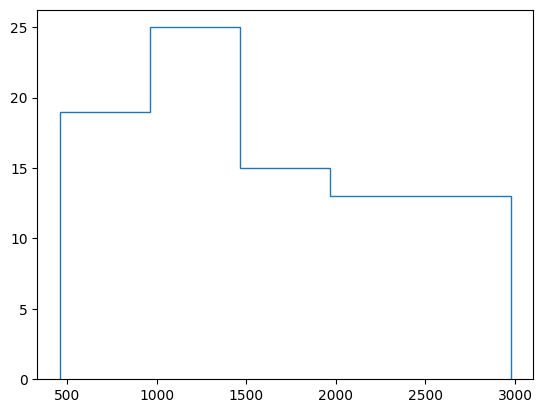

In [87]:
plt.hist(wavelengths,histtype='step',bins='fd')
plt.show()

In [31]:
wavelengths_less750 = wavelengths[wavelengths<=750]
wavelengths_greater750 = wavelengths[wavelengths>=750]

In [32]:
wavelengths_less750,wavelengths_greater750

(array([460.98999 , 500.920013, 540.840027, 580.765015, 620.689941,
        660.609985, 700.537537, 730.47998 ]),
 array([ 750.440002,  770.400024,  790.36499 ,  810.330017,  830.290039,
         850.25    ,  870.209961,  890.174988,  910.140015,  930.099976,
         950.059998,  970.02002 ,  989.97998 , 1009.950012, 1029.910034,
        1049.869995, 1069.829956, 1089.790039, 1109.76001 , 1129.719971,
        1149.679932, 1169.640015, 1189.599976, 1209.570068, 1229.530029,
        1249.48999 , 1269.449951, 1289.410034, 1309.375   , 1329.339966,
        1349.300049, 1369.26001 , 1389.219971, 1409.185059, 1429.150024,
        1449.109985, 1469.070068, 1489.030029, 1508.994995, 1528.959961,
        1548.920044, 1578.859985, 1618.787598, 1658.710083, 1698.630005,
        1738.560059, 1778.47998 , 1818.405029, 1858.330078, 1898.25    ,
        1938.179932, 1978.099976, 2018.022461, 2057.949951, 2097.869873,
        2137.797363, 2177.719971, 2217.642578, 2257.570068, 2297.48999 ,
        23

In [56]:
b = [p5[0],p6[0],p10[0],p22[0],p25[0],p30[0],p45[0],p40[0],p45[0],p50[0],p60[0],p70[0]]
werror = [p5err[0],p6err[0],p10err[0],p22err[0],p25err[0],p30err[0],p35err[0],p40err[0],p45err[0],p50err[0],p60err[0],p70err[0]]

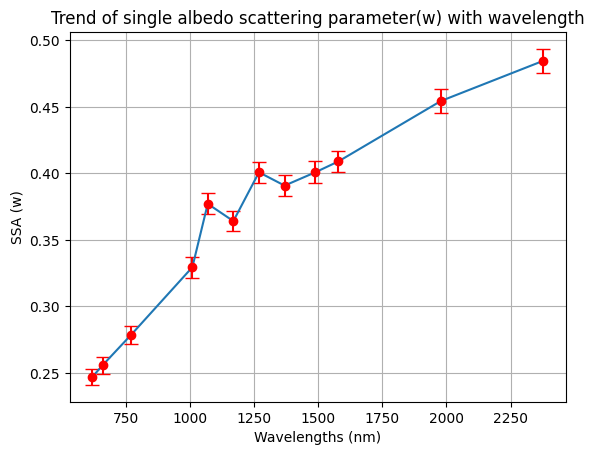

In [57]:
plt.errorbar(a, b, yerr=werror, fmt='o', color='red', capsize=5, label='Data with Error Bars')
plt.plot(a,b)
plt.title('Trend of single albedo scattering parameter(w) with wavelength')
plt.xlabel('Wavelengths (nm)')
plt.ylabel('SSA (w)')
plt.grid()
plt.show()

In [58]:
c = [p5[2],p6[2],p10[2],p22[2],p25[2],p30[2],p45[2],p40[2],p45[2],p50[2],p60[2],p70[2]]
hs_error = [p5err[2],p6err[2],p10err[2],p22err[2],p25err[2],p30err[2],p35err[2],p40err[2],p45err[2],p50err[2],p60err[2],p70err[2]]

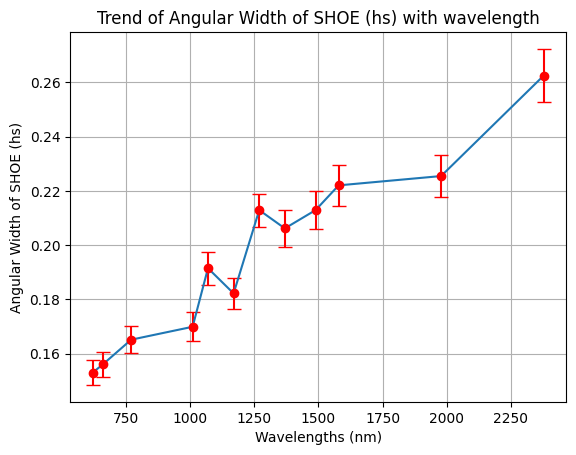

In [59]:
plt.errorbar(a, c, yerr=hs_error, fmt='o', color='red', capsize=5, label='Data with Error Bars')
plt.plot(a,c)
plt.title('Trend of Angular Width of SHOE (hs) with wavelength')
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Angular Width of SHOE (hs)')
plt.grid()
plt.show()

In [60]:
d = [p5[3],p6[3],p10[3],p22[3],p25[3],p30[3],p45[3],p40[3],p45[3],p50[3],p60[3],p70[3]]
Bso_error = [p5err[3],p6err[3],p10err[3],p22err[3],p25err[3],p30err[3],p35err[3],p40err[3],p45err[3],p50err[3],p60err[3],p70err[3]]

In [61]:
d_correct = d - np.mean(d)

In [39]:
d_correct

array([ 1.55672722e-07, -9.93390284e-07,  5.02989054e-07, -6.60174175e-07,
        5.52421002e-07, -6.60174175e-07,  5.51898617e-07,  5.50757238e-07])

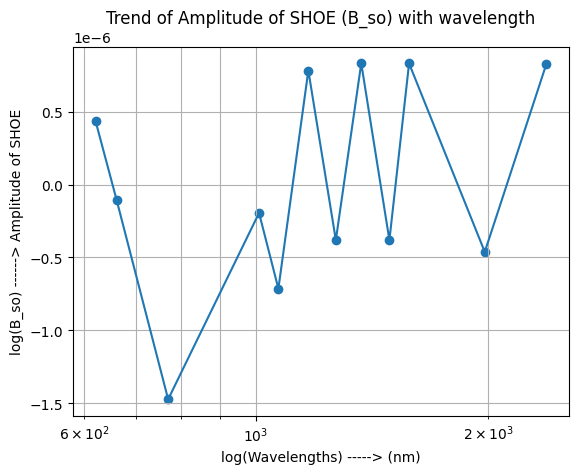

In [73]:
plt.scatter(a, d_correct)
plt.plot(a, d_correct)
plt.title('Trend of Amplitude of SHOE (B_so) with wavelength')
plt.xlabel('log(Wavelengths) -----> (nm)')
plt.ylabel('log(B_so) ------> Amplitude of SHOE')
plt.xscale('log')
plt.grid(which='both', axis='both')  # Display gridlines on both axes
plt.show()

In [63]:
e = [p5[1],p6[1],p10[1],p22[1],p25[1],p30[1],p45[1],p40[1],p45[1],p50[1],p60[1],p70[1]]
b_error = [p5err[1],p6err[1],p10err[1],p22err[1],p25err[1],p30err[1],p35err[1],p40err[1],p45err[1],p50err[1],p60err[1],p70err[1]]

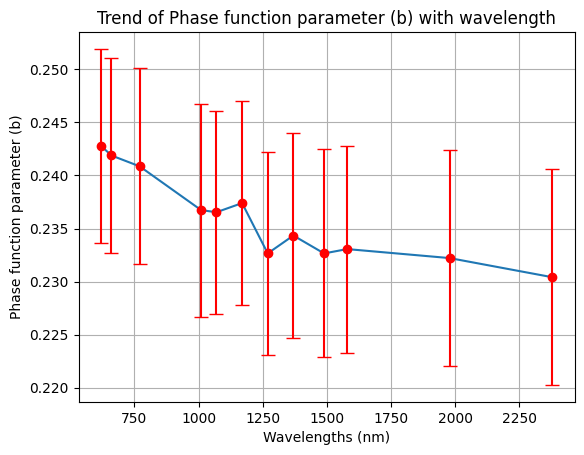

In [64]:
plt.errorbar(a, e, yerr=b_error, fmt='o', color='red', capsize=5, label='Data with Error Bars')
plt.plot(a,e)
plt.title('Trend of Phase function parameter (b) with wavelength')
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Phase function parameter (b)')
plt.grid()
plt.show()

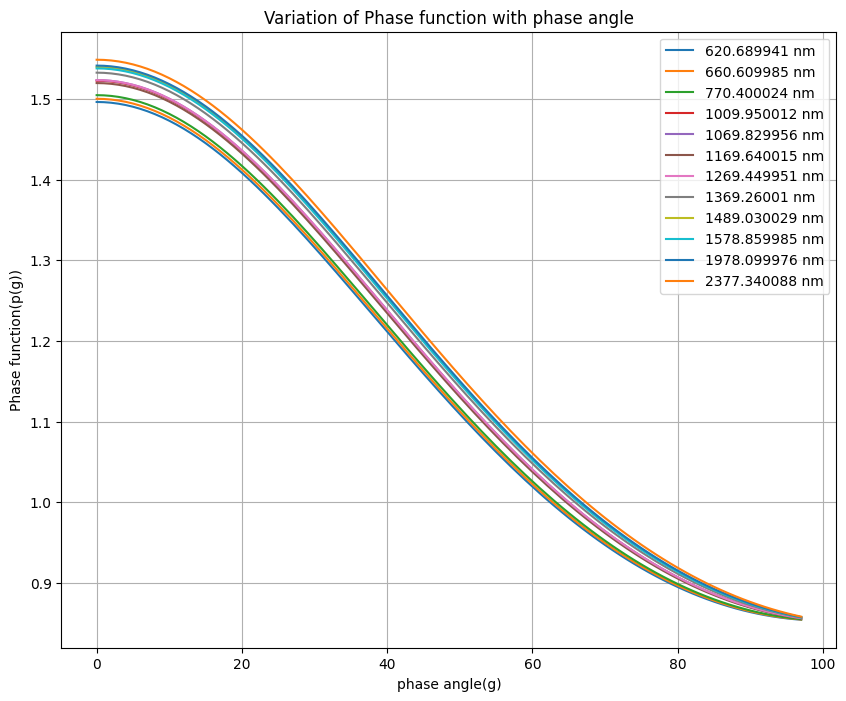

In [68]:
plt.figure(figsize=(10, 8))

g5 = (data5[:,0]*np.pi)/180
g6 = (data6[:,0]*np.pi)/180
g10 = (data10[:,0]*np.pi)/180
g22 = (data22[:,0]*np.pi)/180
g25 = (data25[:,0]*np.pi)/180
g30 = (data30[:,0]*np.pi)/180
g35 = (data35[:,0]*np.pi)/180
g40 = (data40[:,0]*np.pi)/180
g45 = (data45[:,0]*np.pi)/180
g50 = (data50[:,0]*np.pi)/180
g60 = (data60[:,0]*np.pi)/180
g70 = (data70[:,0]*np.pi)/180

plt.plot((g5*180)/np.pi,p(g5,p5[1]),label=f'{a[0]} nm')
plt.plot((g6*180)/np.pi,p(g6,p6[1]),label=f'{a[1]} nm')
plt.plot((g10*180)/np.pi,p(g10,p10[1]),label=f'{a[2]} nm')
plt.plot((g22*180)/np.pi,p(g22,p22[1]),label=f'{a[3]} nm')
plt.plot((g25*180)/np.pi,p(g25,p25[1]),label=f'{a[4]} nm')
plt.plot((g30*180)/np.pi,p(g30,p30[1]),label=f'{a[5]} nm')
plt.plot((g35*180)/np.pi,p(g35,p35[1]),label=f'{a[6]} nm')
plt.plot((g40*180)/np.pi,p(g40,p40[1]),label=f'{a[7]} nm')
plt.plot((g45*180)/np.pi,p(g45,p45[1]),label=f'{a[8]} nm')
plt.plot((g50*180)/np.pi,p(g50,p50[1]),label=f'{a[9]} nm')
plt.plot((g60*180)/np.pi,p(g60,p60[1]),label=f'{a[10]} nm')
plt.plot((g70*180)/np.pi,p(g70,p70[1]),label=f'{a[11]} nm')
plt.grid()
plt.xlabel('phase angle(g)')
plt.ylabel('Phase function(p(g))')
plt.title('Variation of Phase function with phase angle')
plt.legend()
plt.show()

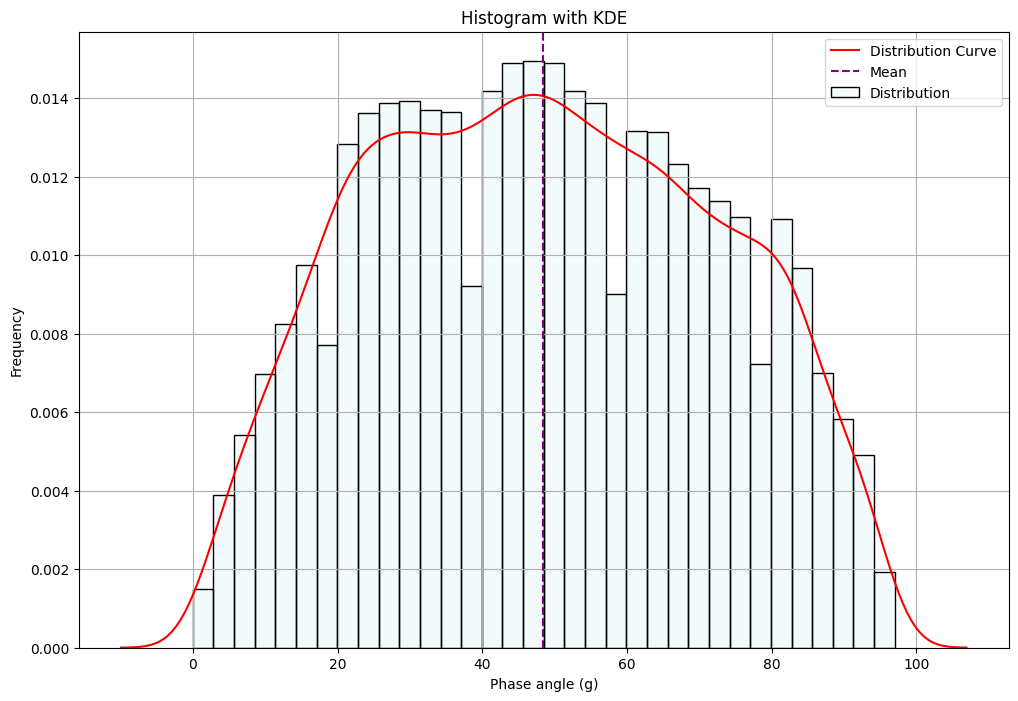

In [69]:
mean_angle = np.mean((g * 180) / np.pi)

# Create the histogram using sns.histplot()
plt.figure(figsize=(12, 8))
sns.histplot((g * 180) / np.pi, bins='fd', kde=False, stat='density', color='skyblue', label='Distribution',alpha=0.1)

# Overlay distribution curve using sns.kdeplot()
sns.kdeplot((g * 180) / np.pi, color='red', label='Distribution Curve')

# Add a vertical line at the mean
plt.axvline(x=mean_angle, color='purple', linestyle='--', label='Mean')

plt.grid()
plt.xlabel('Phase angle (g)')
plt.ylabel('Frequency')
plt.title('Histogram with KDE')
plt.legend()
plt.show()
